In [1]:
#!pip install torch==0.4.0
#!pip install torchvision
#!pip install Pillow==4.1.1

In [1]:
CUDA_LAUNCH_BLOCKING="1"

In [2]:
# Imports here
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets,models,transforms,utils
from torch.autograd import Variable
import copy
import time
from collections import OrderedDict

from PIL import Image

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [4]:
!unzip '/content/gdrive/My Drive/flower_data.zip'

Streaming output truncated to the last 5000 lines.
  inflating: __MACOSX/flower_data/train/53/._image_03687.jpg  
  inflating: flower_data/train/53/image_03730.jpg  
  inflating: __MACOSX/flower_data/train/53/._image_03730.jpg  
  inflating: flower_data/train/53/image_03732.jpg  
  inflating: __MACOSX/flower_data/train/53/._image_03732.jpg  
  inflating: flower_data/train/53/image_03726.jpg  
  inflating: __MACOSX/flower_data/train/53/._image_03726.jpg  
  inflating: flower_data/train/53/image_03685.jpg  
  inflating: __MACOSX/flower_data/train/53/._image_03685.jpg  
  inflating: flower_data/train/53/image_03691.jpg  
  inflating: __MACOSX/flower_data/train/53/._image_03691.jpg  
  inflating: flower_data/train/53/image_03646.jpg  
  inflating: __MACOSX/flower_data/train/53/._image_03646.jpg  
  inflating: flower_data/train/53/image_03647.jpg  
  inflating: __MACOSX/flower_data/train/53/._image_03647.jpg  
  inflating: flower_data/train/53/image_03690.jpg  
  inflating: __MACOSX/flower_

In [5]:
# Check if there is a folder called flower_data
!ls

flower_data  gdrive  __MACOSX  sample_data


In [6]:
data_dir = 'flower_data'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'
data_root = {
    'train': train_dir,
    'valid': valid_dir,
    'test' : test_dir
}

In [7]:
#  Check 
print(data_root['valid'])

flower_data/valid


In [9]:
#Set batch size
batch_size = 16

# TODO: Define your transforms for the training and validation sets
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(45),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
      ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
      ]),
    'test' : transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
    ])


}

# TODO: Load the datasets with ImageFolder
image_datasets = {x: datasets.ImageFolder(data_root[x],data_transforms[x]) for x in ['train','valid','test']}

# TODO: Using the image datasets and the trainforms, define the dataloaders
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x],batch_size=batch_size,shuffle=True) for x in ['train','valid','test'] }

dataset_sizes = {x: len(image_datasets[x]) for x in ['train','valid','test'] }

class_names = image_datasets['train'].classes


In [10]:
print('Train set Images: ',len(image_datasets['train']))
print('Dev set Images: ',len(image_datasets['valid']))
print('Test set Images: ',len(image_datasets['test']))


Train set Images:  6552
Dev set Images:  818
Test set Images:  819


In [11]:
cat_to_name = {"21": "fire lily", "3": "canterbury bells", "45": "bolero deep blue", "1": "pink primrose", "34": "mexican aster", "27": "prince of wales feathers", "7": "moon orchid", "16": "globe-flower", "25": "grape hyacinth", "26": "corn poppy", "79": "toad lily", "39": "siam tulip", "24": "red ginger", "67": "spring crocus", "35": "alpine sea holly", "32": "garden phlox", "10": "globe thistle", "6": "tiger lily", "93": "ball moss", "33": "love in the mist", "9": "monkshood", "102": "blackberry lily", "14": "spear thistle", "19": "balloon flower", "100": "blanket flower", "13": "king protea", "49": "oxeye daisy", "15": "yellow iris", "61": "cautleya spicata", "31": "carnation", "64": "silverbush", "68": "bearded iris", "63": "black-eyed susan", "69": "windflower", "62": "japanese anemone", "20": "giant white arum lily", "38": "great masterwort", "4": "sweet pea", "86": "tree mallow", "101": "trumpet creeper", "42": "daffodil", "22": "pincushion flower", "2": "hard-leaved pocket orchid", "54": "sunflower", "66": "osteospermum", "70": "tree poppy", "85": "desert-rose", "99": "bromelia", "87": "magnolia", "5": "english marigold", "92": "bee balm", "28": "stemless gentian", "97": "mallow", "57": "gaura", "40": "lenten rose", "47": "marigold", "59": "orange dahlia", "48": "buttercup", "55": "pelargonium", "36": "ruby-lipped cattleya", "91": "hippeastrum", "29": "artichoke", "71": "gazania", "90": "canna lily", "18": "peruvian lily", "98": "mexican petunia", "8": "bird of paradise", "30": "sweet william", "17": "purple coneflower", "52": "wild pansy", "84": "columbine", "12": "colt's foot", "11": "snapdragon", "96": "camellia", "23": "fritillary", "50": "common dandelion", "44": "poinsettia", "53": "primula", "72": "azalea", "65": "californian poppy", "80": "anthurium", "76": "morning glory", "37": "cape flower", "56": "bishop of llandaff", "60": "pink-yellow dahlia", "82": "clematis", "58": "geranium", "75": "thorn apple", "41": "barbeton daisy", "95": "bougainvillea", "43": "sword lily", "83": "hibiscus", "78": "lotus lotus", "88": "cyclamen", "94": "foxglove", "81": "frangipani", "74": "rose", "89": "watercress", "73": "water lily", "46": "wallflower", "77": "passion flower", "51": "petunia"}

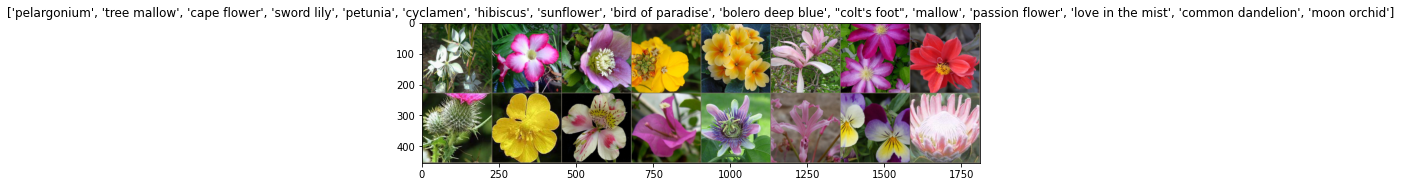

In [12]:
fig,ax = plt.subplots(figsize=(10,10))
def imshow(inp,title=None):
  inp = inp.numpy().transpose((1, 2, 0))
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  ax.imshow(inp)
  if title is not None:
      plt.title(title)
  plt.pause(0.001) 
  
  # Get a batch of training data
inputs, classes = next(iter(dataloaders['test']))

# Make a grid from batch
out = utils.make_grid(inputs)

imshow(out, title=[cat_to_name[str(x.item())] for x in classes])

#for x in classes:
 # print(x.item(), cat_to_name[str(x.item())] )

### Model 1 -> ResNet152

In [13]:
modelA = models.resnet152(pretrained=True)

for param in modelA.parameters():
  param.requires_grad=False

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/checkpoints/resnet152-b121ed2d.pth


In [14]:
# move the model to GPU, if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if(device.type=="cuda"):
  print("Running on CUDA")

Running on CUDA


In [15]:
classifierA = nn.Linear(2048,102)
modelA.fc = classifierA


In [16]:
use_gpu = torch.cuda.is_available() # if gpu is available then use it
if use_gpu:
   modelA = modelA.cuda()

loss_fn_A = nn.CrossEntropyLoss()
optimizerA = optim.Adam(modelA.fc.parameters(),lr=0.001)
schedulerA = optim.lr_scheduler.StepLR(optimizerA,step_size=5,gamma=0.1)
#optimizerA = optim.SGD(modelA.parameters(), lr=0.0001, momentum=0.9)



In [17]:
# Find total parameters and trainable parameters
total_params = sum(p.numel() for p in modelA.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in modelA.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} trainable parameters.')

58,352,806 total parameters.
208,998 trainable parameters.


In [18]:
# TODO: Save the checkpoint 
def save_checkpoint(file_path,model,optimizer,best_acc,num_epochs):
  model.class_to_idx = image_datasets['train'].class_to_idx
  torch.save({
      'arch': 'resnet152',
      'num_epochs': num_epochs,
      'best_acc': best_acc,
      'model_state_dict': model.state_dict(),
      'optim_state_dict': optimizer.state_dict(),
      'class_to_idx': model.class_to_idx
  },file_path)
  print('Epochs {} \t Best Accuracy {:.4f}'.format(num_epochs,best_acc))
  print('!!!!!!!!!Checkpoint Saved!!!!!!!')

In [19]:
def train_model(model, criterion, optimizer, scheduler, checkpoint, num_epochs=25,device='cuda'):
    since = time.time()

    train_error = []
    valid_error = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                #scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                       
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            if phase == 'train':
              train_error.append(epoch_loss)
            if phase == 'valid':
              valid_error.append(epoch_loss)
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
 
            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                print('Saving model....')
                model.cpu()
                # Save model to start retraining from there
                path = '/content/gdrive/My Drive/' + checkpoint
                save_checkpoint(path,model,optimizer,best_acc,epoch)
                model.cuda()

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_error, valid_error

In [20]:
modelA.to(device)
#optimizerA.zero_grad()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [42]:
model_ft, train_error, valid_error = train_model(modelA,loss_fn_A,optimizerA,schedulerA,'checkpoint_resnet_2.pth',15,device)

Epoch 0/14
----------


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 2.1016 Acc: 0.5522
valid Loss: 0.6879 Acc: 0.8399
Saving model....
Epochs 0 	 Best Accuracy 0.8399
!!!!!!!!!Checkpoint Saved!!!!!!!

Epoch 1/14
----------
train Loss: 0.8865 Acc: 0.7801
valid Loss: 0.4012 Acc: 0.9046
Saving model....
Epochs 1 	 Best Accuracy 0.9046
!!!!!!!!!Checkpoint Saved!!!!!!!

Epoch 2/14
----------
train Loss: 0.6662 Acc: 0.8248
valid Loss: 0.3384 Acc: 0.9156
Saving model....
Epochs 2 	 Best Accuracy 0.9156
!!!!!!!!!Checkpoint Saved!!!!!!!

Epoch 3/14
----------
train Loss: 0.6105 Acc: 0.8387
valid Loss: 0.2908 Acc: 0.9291
Saving model....
Epochs 3 	 Best Accuracy 0.9291
!!!!!!!!!Checkpoint Saved!!!!!!!

Epoch 4/14
----------
train Loss: 0.4116 Acc: 0.8947
valid Loss: 0.2026 Acc: 0.9474
Saving model....
Epochs 4 	 Best Accuracy 0.9474
!!!!!!!!!Checkpoint Saved!!!!!!!

Epoch 5/14
----------
train Loss: 0.4109 Acc: 0.8973
valid Loss: 0.2182 Acc: 0.9450

Epoch 6/14
----------
train Loss: 0.4063 Acc: 0.9009
valid Loss: 0.2035 Acc: 0.9438

Epoch 7/14
------

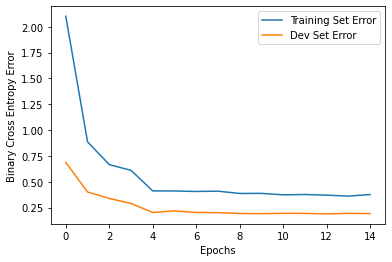

In [21]:
train_error = [2.1016,0.8865,0.6662,0.6105,0.4116,0.4109,0.4063,0.4090,0.3869,0.3877,0.3737,0.3768,0.3706,0.3611,0.3765]
valid_error = [0.6879,0.4012,0.3384,0.2908,0.2026,0.2182,0.2035,0.2016,0.1931,0.1917,0.1947,0.1943,0.1890,0.1949,0.1927]
epochs = [i for i in range(15)]
import matplotlib.pyplot as plt
plt.plot(epochs,train_error,label='Training Set Error')
plt.plot(epochs,valid_error,label='Dev Set Error')
plt.xlabel('Epochs')
plt.ylabel('Binary Cross Entropy Error')
plt.legend()
plt.show()

In [21]:
# TODO: Write a function that loads a checkpoint and rebuilds the model
def load_checkpoint(file_path,model,optimizer):
  print(file_path)
  checkpoint = torch.load(file_path)
  print('Epochs {} \n Best Accuracy {}'.format(checkpoint['num_epochs'], checkpoint['best_acc']))
        
  if checkpoint['arch'] == 'resnet152':
    model = models.resnet152(pretrained=True)
    for param in model.parameters():
      param.requires_grad= False    
  else: 
    print('Architecture mistmatch')
    return None
  
  
  model.class_to_idx = checkpoint['class_to_idx']
    
  # Create the classifier
  classifier = nn.Linear(2048,102)
  # Put the classifier on the pretrained network
  model.fc = classifier
    
  model.load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optim_state_dict'])
  return model

In [22]:
model_ft = load_checkpoint('/content/gdrive/My Drive/checkpoint_resnet_2.pth',modelA,optimizerA)

/content/gdrive/My Drive/checkpoint_resnet_2.pth
Epochs 9 
 Best Accuracy 0.9572127139364303


In [23]:
def calc_test_accuracy(model,type_set):
  model.eval()
  model.to(device)    
    
  running_corrects = 0
  
  with torch.no_grad():
    for (inputs, labels) in dataloaders[type_set]:
      inputs, labels = inputs.cuda(), labels.cuda()
      # obtain the outputs from the model
      outputs = model.forward(inputs)
      # max provides the (maximum probability, max value)
      _, preds = torch.max(outputs,dim=1)
      running_corrects += torch.sum(preds == labels.data)

  acc = running_corrects.double() / len(image_datasets[type_set])
  print(type_set,' Accuracy: ',acc)


In [24]:
calc_test_accuracy(model_ft,'train')
calc_test_accuracy(model_ft,'valid')
calc_test_accuracy(model_ft,'test')

train  Accuracy:  tensor(0.9272, device='cuda:0', dtype=torch.float64)
valid  Accuracy:  tensor(0.9572, device='cuda:0', dtype=torch.float64)
test  Accuracy:  tensor(0.9402, device='cuda:0', dtype=torch.float64)


In [25]:
def get_preds_labels(model):
    model.eval()
    model.to(device)

    predictions = torch.tensor([],dtype=torch.int64,device='cuda:0')
    test_labels = torch.tensor([],dtype=torch.int64,device='cuda:0')

    with torch.no_grad(): 
        for (inputs, labels) in dataloaders['test']:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            predictions = torch.cat((predictions,preds))
            test_labels = torch.cat((test_labels,labels))
            
    return predictions, test_labels


In [26]:
preds, labels = get_preds_labels(model_ft)

In [27]:
print(preds.shape)
print(labels.shape)
print(labels.unsqueeze(1).shape)

torch.Size([819])
torch.Size([819])
torch.Size([819, 1])


In [28]:
stacked = torch.cat((preds.unsqueeze(1),labels.unsqueeze(1)),dim=1)
stacked.shape

torch.Size([819, 2])

In [29]:
cmt = torch.zeros(102,102, dtype=torch.int64)
for p in stacked:
    j, k = p.tolist()
    cmt[j, k] = cmt[j, k] + 1

In [30]:
cmt

tensor([[5, 0, 0,  ..., 0, 0, 0],
        [0, 3, 0,  ..., 0, 0, 0],
        [0, 0, 8,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 4, 0, 0],
        [0, 0, 0,  ..., 0, 3, 0],
        [0, 0, 0,  ..., 0, 0, 7]])

In [31]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
import numpy as np

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')



In [32]:
names = [i for i in range(1,103)]

Confusion matrix, without normalization
tensor([[5, 0, 0,  ..., 0, 0, 0],
        [0, 3, 0,  ..., 0, 0, 0],
        [0, 0, 8,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 4, 0, 0],
        [0, 0, 0,  ..., 0, 3, 0],
        [0, 0, 0,  ..., 0, 0, 7]])


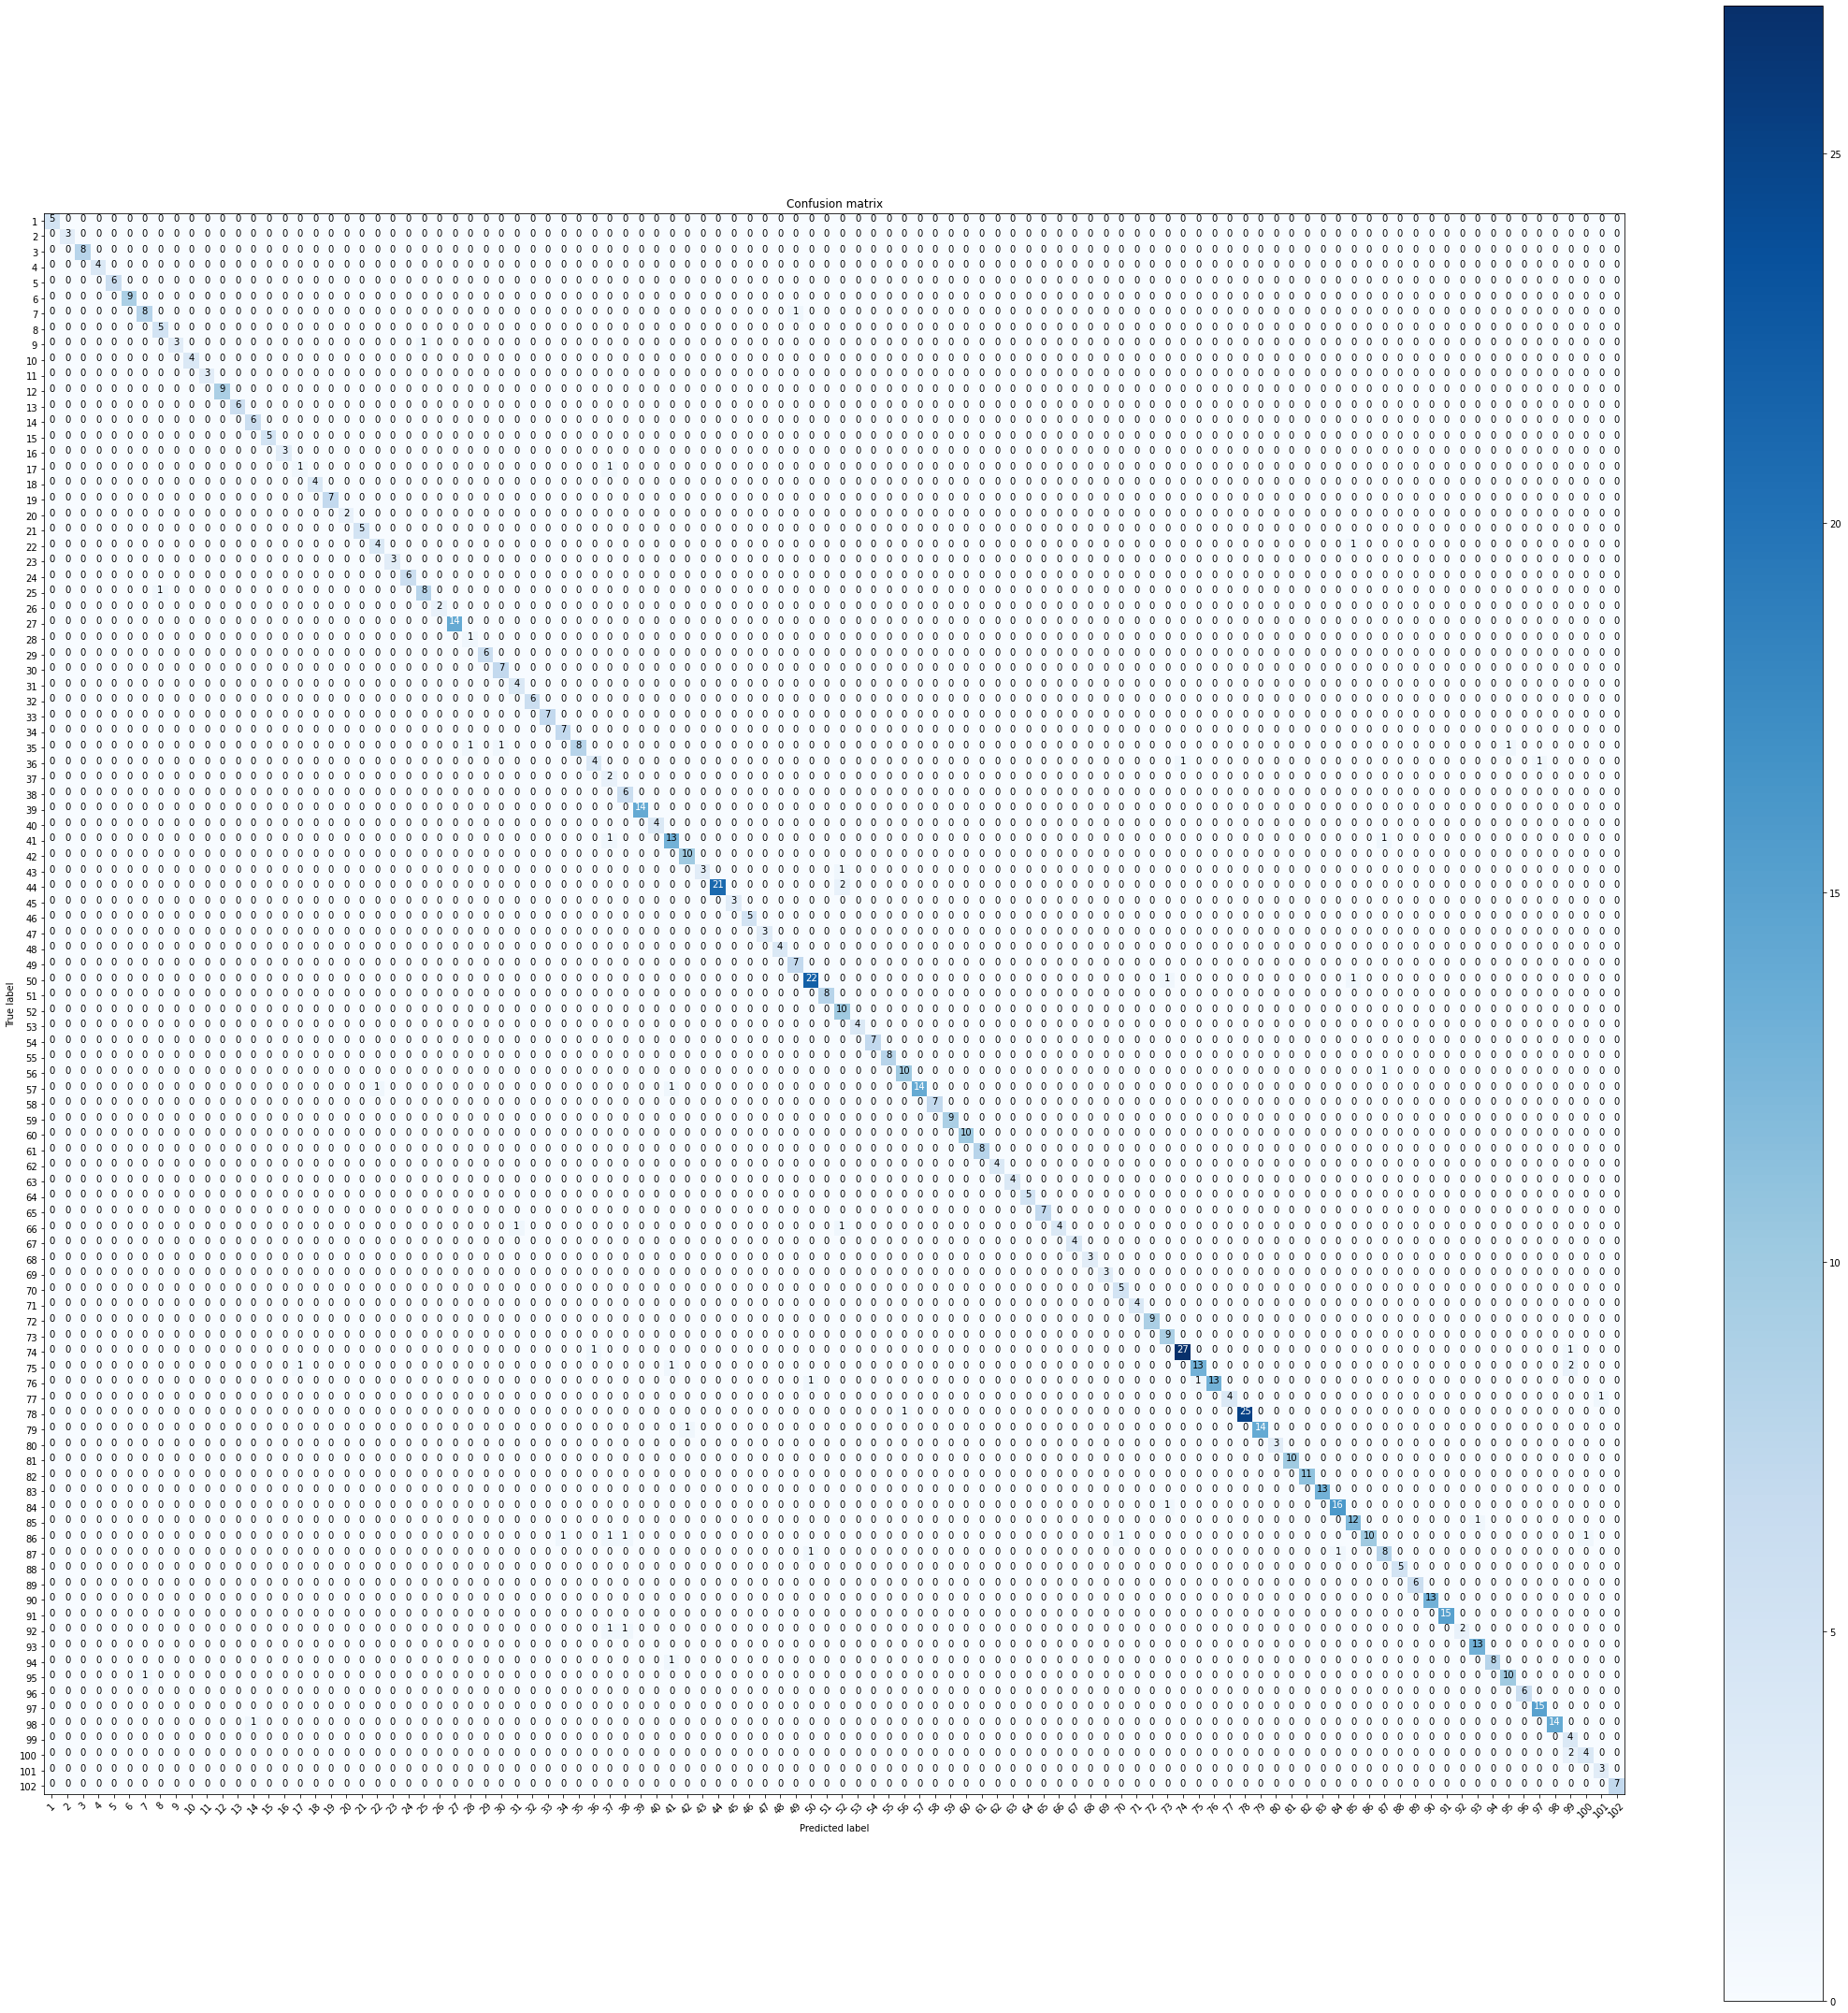

In [33]:
plt.figure(figsize=(30,30))
plot_confusion_matrix(cmt, names)

In [34]:
def process_image(image_path):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    pil_img = Image.open(image_path)
    
    #resize and crop
    loader = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor()
    ])
    
    pil_img = loader(pil_img).float()
    
    # Convert to numpy array
    np_img = np.array(pil_img)/255
    
    # Normalize the pixel values
    mean =  np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    np_img = (np.transpose(np_img, (1, 2, 0)) - mean)/std
    
    # Transpose
    np_img = np.transpose(np_img,(2, 0, 1))
    
    return np_img

In [35]:
def imgshow(image, ax=None, title='Sample Flower'):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = np.transpose(image, (1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    image = image*255
    ax.imshow(image)
    
    if title is not None:
      plt.title(title)
    return ax

In [ ]:
#pink primose
image_path = test_dir + '/1/image_06752.jpg'
i = process_image(image_path)
imgshow(i)
i = torch.tensor(i,dtype=torch.float32,device=device)
i = i.unsqueeze(0)
i.shape
model_ft.forward(i)

In [ ]:
#pink primose
image_path = test_dir + '/12/image_03994.jpg'
i = process_image(image_path)
imgshow(i)
i = torch.tensor(i,dtype=torch.float32,device='cuda:0')
i = i.unsqueeze(0)
i.shape
out = model_ft.forward(i)
loss = nn.CrossEntropyLoss()
lst = []
for i in range(102):
     label = torch.tensor([i],dtype=torch.long,device='cuda:0')
     lst.append(loss(out,label).item())
print(lst)

###Model 2 -> Vgg19

In [34]:
model_vgg = models.vgg19(pretrained=True)

for param in model_vgg.parameters():
        param.requires_grad=False

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/checkpoints/vgg19-dcbb9e9d.pth


In [35]:
n_inputs = 4096
n_classes = 102
model_vgg.classifier[6] = nn.Linear(n_inputs, n_classes)


print(model_vgg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [36]:
# Find total parameters and trainable parameters
total_params = sum(p.numel() for p in model_vgg.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in model_vgg.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} trainable parameters.')

139,988,134 total parameters.
417,894 trainable parameters.


In [37]:
model_vgg = model_vgg.to('cuda')

In [52]:
loss_fn_vgg = nn.CrossEntropyLoss()
optimizer_vgg = optim.Adam(model_vgg.classifier.parameters(),lr=0.0001)
scheduler_vgg = optim.lr_scheduler.StepLR(optimizer_vgg,step_size=4,gamma=0.1)

In [ ]:
model_ft_2 = train_model(model_vgg,loss_fn_vgg,optimizer_vgg,scheduler_vgg,'checkpoint_vgg.pth',20,device)

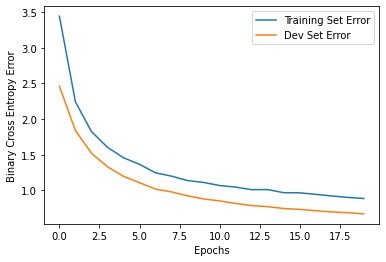

In [58]:
train_error = [3.4444,2.2418,1.8246,1.6033,1.4567,1.3642,1.2444,1.1982,1.1359,1.1097,1.0665,1.0443,1.0078,1.0096,0.9658,0.9636,0.9426,0.9199,0.8996,0.8839]
valid_error = [2.4613,1.8373,1.5201,1.3305,1.1963,1.1063,1.0161,0.9765,0.9219,0.8778,0.8509,0.8141,0.7848,0.7698,0.7436,0.7311,0.7123,0.6953,0.6856,0.6676]
epochs = [i for i in range(20)]
import matplotlib.pyplot as plt
plt.plot(epochs,train_error,label='Training Set Error')
plt.plot(epochs,valid_error,label='Dev Set Error')
plt.xlabel('Epochs')
plt.ylabel('Binary Cross Entropy Error')
plt.legend()
plt.show()

In [64]:
model_ft_2 = load_checkpoint('/content/gdrive/My Drive/checkpoint_vgg.pth',model_vgg,optimizer_vgg)

/content/gdrive/My Drive/checkpoint_vgg.pth
Epochs 18 
 Best Accuracy 0.8361858190709046
Architecture mistmatch


In [ ]:
print(calc_test_accuracy(model_ft_2,'valid'))
print(calc_test_accuracy(model_ft_2,'train'))
print(calc_test_accuracy(model_ft_2,'test'))

### Model 3 -> AlexNet

In [73]:
model_alexnet = models.alexnet(pretrained=True)

for param in model_alexnet.parameters():
  param.requires_grad=False



In [74]:
model_alexnet.classifier[6] = nn.Linear(4096,102)

use_gpu = torch.cuda.is_available()
if use_gpu:
    model_alexnet = model_alexnet.cuda()

loss_fn_alexnet = nn.CrossEntropyLoss()
optimizer_alexnet = optim.Adam(model_alexnet.classifier.parameters(),lr=0.001)
scheduler_alexnet = optim.lr_scheduler.StepLR(optimizer_alexnet,step_size=5,gamma=0.1)


In [75]:
model_alexnet.to(device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [76]:
model_ft_3, a_train, a_valid = train_model(model_alexnet,loss_fn_alexnet,optimizer_alexnet,scheduler_alexnet,'checkpoint_alexnet.pth',15,device)

Epoch 0/14
----------
train Loss: 1.9954 Acc: 0.5336
valid Loss: 0.9220 Acc: 0.7726
Saving model....
Epochs 0 	 Best Accuracy 0.7726
!!!!!!!!!Checkpoint Saved!!!!!!!

Epoch 1/14
----------
train Loss: 1.2818 Acc: 0.6821
valid Loss: 0.8289 Acc: 0.7787
Saving model....
Epochs 1 	 Best Accuracy 0.7787
!!!!!!!!!Checkpoint Saved!!!!!!!

Epoch 2/14
----------
train Loss: 1.1525 Acc: 0.7163
valid Loss: 0.7817 Acc: 0.8093
Saving model....
Epochs 2 	 Best Accuracy 0.8093
!!!!!!!!!Checkpoint Saved!!!!!!!

Epoch 3/14
----------
train Loss: 1.1997 Acc: 0.7169
valid Loss: 0.7107 Acc: 0.8178
Saving model....
Epochs 3 	 Best Accuracy 0.8178
!!!!!!!!!Checkpoint Saved!!!!!!!

Epoch 4/14
----------
train Loss: 1.0990 Acc: 0.7431
valid Loss: 0.7621 Acc: 0.8227
Saving model....
Epochs 4 	 Best Accuracy 0.8227
!!!!!!!!!Checkpoint Saved!!!!!!!

Epoch 5/14
----------
train Loss: 1.0551 Acc: 0.7572
valid Loss: 0.7210 Acc: 0.8337
Saving model....
Epochs 5 	 Best Accuracy 0.8337
!!!!!!!!!Checkpoint Saved!!!!!!!

In [77]:
# Find total parameters and trainable parameters
total_params = sum(p.numel() for p in model_alexnet.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in model_alexnet.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} trainable parameters.')

57,421,734 total parameters.
417,894 trainable parameters.


In [78]:
model_ft_3 = load_checkpoint('/content/gdrive/My Drive/checkpoint_vgg.pth',model_alexnet,optimizer_alexnet)

/content/gdrive/My Drive/checkpoint_vgg.pth
Epochs 18 
 Best Accuracy 0.8361858190709046
Architecture mistmatch


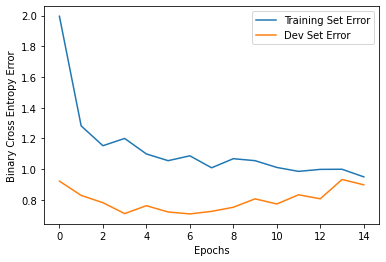

In [80]:
train_error = a_train
valid_error = a_valid
epochs = [i for i in range(15)]
import matplotlib.pyplot as plt
plt.plot(epochs,train_error,label='Training Set Error')
plt.plot(epochs,valid_error,label='Dev Set Error')
plt.xlabel('Epochs')
plt.ylabel('Binary Cross Entropy Error')
plt.legend()
plt.show()